In [43]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import exponential_family as ef
import classification_with_rejection as cwr
from framework.mnist_setting import (Multinomial, FC_Model, view_image,
    view_image_pred, view_image_cwr, view_image_rej,
    zero_one_classification_loss)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Q2: Exponential Families

Using the theory introduced in Q2, we are able to define an exponential family parameterized by a neural network. The following defines such an exponential family which encodes a Multinomial distribution. This allows us to train a neural network to classify a subset of the MNIST dataset.

In [68]:
train_kwargs = {'batch_size': 256}
test_kwargs = {'batch_size': 1_000}

spec_classes = 5
display_many = 20
class_labels = list(range(spec_classes))

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
pre_train_dataset = datasets.MNIST('data', train=True,
                    transform=transform)
pre_test_dataset = datasets.MNIST('data', train=False,
                    transform=transform)

indices1 = [i for i, (_, l) in enumerate(pre_train_dataset) \
            if l in class_labels]
indices2 = [i for i, (_, l) in enumerate(pre_test_dataset) \
            if l in class_labels]

train_dataset = torch.utils.data.Subset(pre_train_dataset, indices1)
test_dataset = torch.utils.data.Subset(pre_test_dataset, indices2)

view_indices = torch.randint(0, len(test_dataset), (display_many,)).tolist()

train_loader = torch.utils.data.DataLoader(train_dataset,**train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

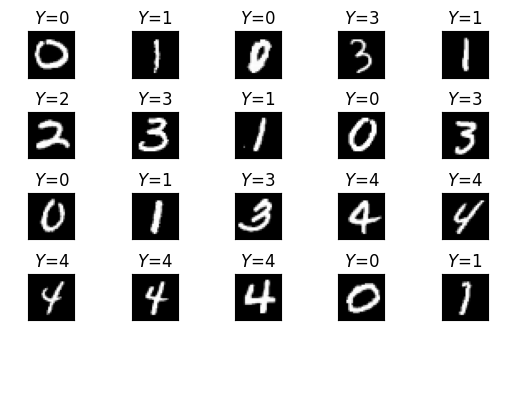

In [69]:
view_image(view_indices, test_dataset)

In [70]:
exp_fam: Multinomial = Multinomial(n_classes = spec_classes)
model: FC_Model = FC_Model(n_classes = spec_classes)

In [71]:
parameters: torch.Tensor = model.make_random_parameter()

In [72]:
epochs = 14
lr = 1
gamma = 0.7

train_hist = []
test_hist = []

def update_hist():
    train_zero_one = 0
    test_zero_one = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        train_zero_one += len(data) * zero_one_classification_loss(
            model, data, target, parameters)
    train_zero_one = train_zero_one / len(train_dataset)

    for batch_idx, (data, target) in enumerate(test_loader):
        test_zero_one += len(data) * zero_one_classification_loss(
            model, data, target, parameters)
    test_zero_one = test_zero_one / len(test_dataset)

    train_hist.append(train_zero_one)
    test_hist.append(test_zero_one)

    return train_zero_one, test_zero_one

train_zero_one, test_zero_one = update_hist()
print(f'Epoch {0} train 0-1: {train_zero_one}; test 0-1: {test_zero_one}')
for e in range(1, epochs+1):
    for batch_idx, (data, target) in enumerate(train_loader):
        parameters = ef.update(exp_fam, model, data, target, parameters, len(data), lr = lr)

    train_zero_one, test_zero_one = update_hist()
    print(f'Epoch {e} train 0-1: {train_zero_one}; test 0-1: {test_zero_one}')

    lr = lr * gamma


Epoch 0 train 0-1: 0.7678781747817993; test 0-1: 0.7750535011291504
Epoch 1 train 0-1: 0.06576023250818253; test 0-1: 0.06343646347522736
Epoch 2 train 0-1: 0.050333376973867416; test 0-1: 0.05351235717535019
Epoch 3 train 0-1: 0.042881421744823456; test 0-1: 0.04689628258347511
Epoch 4 train 0-1: 0.0384363979101181; test 0-1: 0.044561199843883514
Epoch 5 train 0-1: 0.03598509728908539; test 0-1: 0.044366609305143356
Epoch 6 train 0-1: 0.034775786101818085; test 0-1: 0.0441720187664032
Epoch 7 train 0-1: 0.034122105687856674; test 0-1: 0.04378283768892288
Epoch 8 train 0-1: 0.0336972139775753; test 0-1: 0.043588247150182724
Epoch 9 train 0-1: 0.03343574330210686; test 0-1: 0.043393656611442566
Epoch 10 train 0-1: 0.03291279822587967; test 0-1: 0.043393656611442566
Epoch 11 train 0-1: 0.03281474858522415; test 0-1: 0.043393656611442566
Epoch 12 train 0-1: 0.032651327550411224; test 0-1: 0.04319906607270241
Epoch 13 train 0-1: 0.03258595988154411; test 0-1: 0.04319906607270241
Epoch 14 t

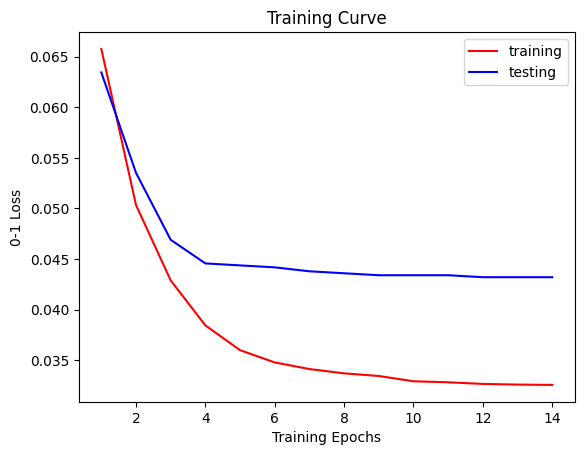

In [73]:
plt.plot(range(1, epochs + 1), train_hist[1:], c='r', label='training')
plt.plot(range(1, epochs + 1), test_hist[1:], c='b', label='testing')

plt.title('Training Curve')
plt.xlabel('Training Epochs')
plt.ylabel('0-1 Loss')
plt.legend()
plt.show()

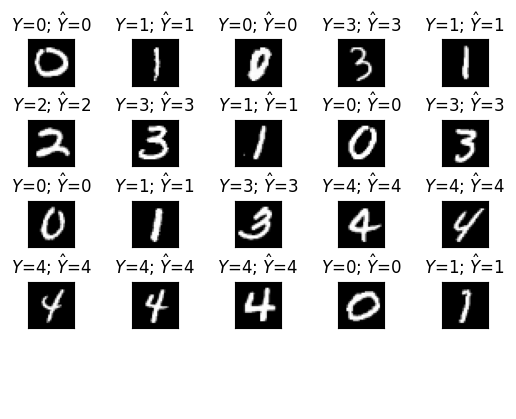

In [74]:
view_image_pred(view_indices, test_dataset, model, parameters)

# Q3 Classification with Rejection
By using some of the theory on classification with rejection, we can use the previously trained exponential family to add rejection.

In [75]:
# Uncomment the following to load backup weights if Q2 is not completed.
#parameters = torch.load('data/backup_weights.pt')

In [76]:
rejection_cost = 0.1

In [77]:
r_preds = []
cwr_preds = []
for batch_idx, (data, target) in enumerate(test_loader):

    cur_r_pred = cwr.r_reject_pred(
        exp_fam, model, parameters, data, spec_classes, rejection_cost,
        len(data))

    cur_cwr_pred = cwr.cwr_pred(
        exp_fam, model, parameters, data, spec_classes, rejection_cost,
        len(data))

    for i in range(len(data)):
        r_preds.append(cur_r_pred[i])
        cwr_preds.append(cur_cwr_pred[i])
    
r_preds = torch.stack(r_preds)
cwr_preds = torch.stack(cwr_preds).int()

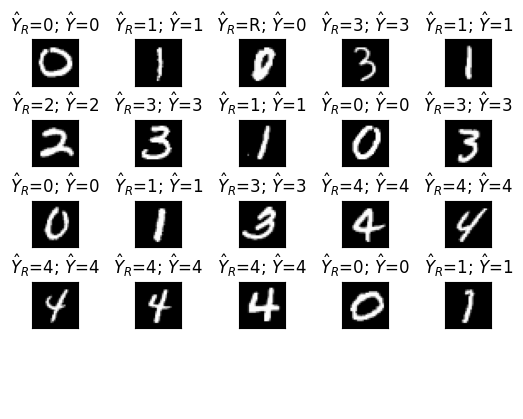

In [78]:
view_image_cwr(view_indices, test_dataset, model, parameters, cwr_preds)

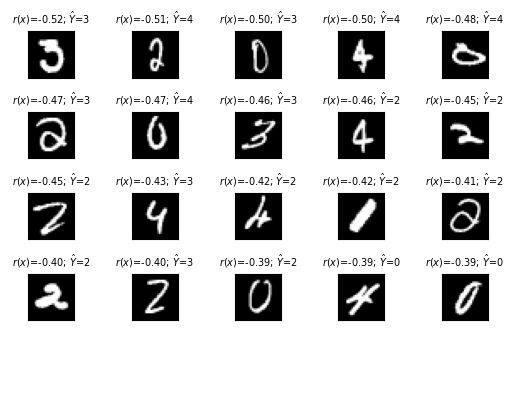

In [79]:
# Highest rejected
rej_indices = [i for i in torch.argsort(r_preds)[:display_many]]
view_image_rej(rej_indices, test_dataset, model, parameters, r_preds)

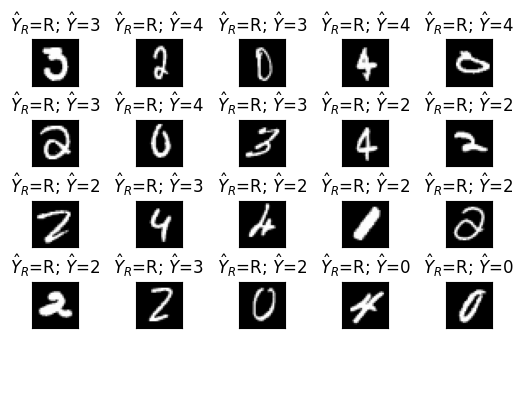

In [80]:
# Check we are indeed rejecting correctly
view_image_cwr(rej_indices, test_dataset, model, parameters, cwr_preds)